In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import yfinance as yf
import ta  # Technical Analysis library for financial indicators
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import plotly.express as px

In [2]:
# Data Collection
data = yf.download('BTC-USD', start='2022-01-01', end='2023-11-15')
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]  # Using multiple features


[*********************100%***********************]  1 of 1 completed


In [3]:
# Save the DataFrame to a CSV file
data.to_csv('bitcoin_trading_data.csv', index=True)

In [4]:
# Read the DataFrame from the CSV file
data = pd.read_csv('bitcoin_trading_data.csv', index_col=0)

In [5]:
# Preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [6]:
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), :])
        Y.append(dataset[i + time_step, 3])  # Target is still the 'Close' price
    return np.array(X), np.array(Y)

time_step = 60
X, y = create_dataset(scaled_data, time_step)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




In [7]:
# LSTM Model
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))


In [8]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [9]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Training with potentially adjusted batch size and epochs
model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.1, callbacks=[early_stopping, reduce_lr])

# Prediction and Evaluation
y_pred = model.predict(X_test)
y_test_scaled_back = scaler.inverse_transform(np.concatenate((np.zeros_like(y_test).reshape(-1,1), y_test.reshape(-1,1), np.zeros((len(y_test), scaled_data.shape[1] - 2))), axis=1))[:, 1]
dummy_test = np.zeros((len(y_pred), scaled_data.shape[1]))
dummy_test[:, 3] = y_pred.flatten()
y_pred_transformed = scaler.inverse_transform(dummy_test)[:, 3]

r_squared = r2_score(y_test_scaled_back, y_pred_transformed)
mse = mean_squared_error(y_test_scaled_back, y_pred_transformed)
mae = mean_absolute_error(y_test_scaled_back, y_pred_transformed)

print("R-Squared score:", r_squared)
print("MSE:", mse)
print("MAE:", mae)


Epoch 1/200
14/14 [==============================] - 4s 102ms/step - loss: 0.0265 - val_loss: 0.0046 - lr: 0.0010
Epoch 2/200
14/14 [==============================] - 1s 60ms/step - loss: 0.0053 - val_loss: 0.0052 - lr: 0.0010
Epoch 3/200
14/14 [==============================] - 1s 62ms/step - loss: 0.0045 - val_loss: 0.0038 - lr: 0.0010
Epoch 4/200
14/14 [==============================] - 1s 59ms/step - loss: 0.0042 - val_loss: 0.0035 - lr: 0.0010
Epoch 5/200
14/14 [==============================] - 1s 60ms/step - loss: 0.0041 - val_loss: 0.0033 - lr: 0.0010
Epoch 6/200
14/14 [==============================] - 1s 61ms/step - loss: 0.0036 - val_loss: 0.0030 - lr: 0.0010
Epoch 7/200
14/14 [==============================] - 1s 65ms/step - loss: 0.0033 - val_loss: 0.0032 - lr: 0.0010
Epoch 8/200
14/14 [==============================] - 1s 62ms/step - loss: 0.0033 - val_loss: 0.0030 - lr: 0.0010
Epoch 9/200
14/14 [==============================] - 1s 61ms/step - loss: 0.0032 - val_loss: 0.

In [10]:
# Predict the next day's closing price
last_sequence = scaled_data[-time_step:]
last_sequence = last_sequence.reshape(1, time_step, scaled_data.shape[1])
next_day_prediction = model.predict(last_sequence)
next_day_dummy = np.zeros((1, scaled_data.shape[1]))
next_day_dummy[:, 3] = next_day_prediction.flatten()
predicted_close_price = scaler.inverse_transform(next_day_dummy)[:, 3]

print("Predicted Next Day Price:", predicted_close_price)

1/1 [==============================] - 0s 21ms/step
Predicted Next Day Price: [36298.42822171]


In [11]:
# Predict the next day
last_sequence = scaled_data[-time_step:]
last_sequence = last_sequence.reshape(1, time_step, 5)
next_day_prediction = model.predict(last_sequence)
predicted_close_price = scaler.inverse_transform(np.concatenate((next_day_prediction, np.zeros((1, 4))), axis=1))[:, 0]

1/1 [==============================] - 0s 22ms/step


In [12]:
# Predict the next day's closing price
last_sequence = scaled_data[-time_step:]
last_sequence = last_sequence.reshape(1, time_step, 5)
next_day_prediction = model.predict(last_sequence)

# Adjust the shape of next_day_prediction for inverse transformation
next_day_dummy = np.zeros((1, scaled_data.shape[1]))
next_day_dummy[:, 3] = next_day_prediction.flatten()
predicted_close_price = scaler.inverse_transform(next_day_dummy)[:, 3]

# Print the predicted next day price
print("Predicted Next Day Price:", predicted_close_price)
print("Actual values:", y_test[:10])
print("Predicted values:", y_pred_transformed[:10])
print("X_test shape:", X_test.shape)


1/1 [==============================] - 0s 20ms/step
Predicted Next Day Price: [36298.42822171]
Actual values: [0.1611059  0.38842895 0.17996516 0.03325575 0.15085655 0.14727457
 0.1091179  0.10283383 0.33608436 0.25256181]
Predicted values: [20290.81803395 28030.09403362 21168.21774313 17181.62126346
 19549.42260944 20455.39167945 19030.8544621  19040.04017019
 26652.24114734 21658.22389741]
X_test shape: (125, 60, 5)


In [13]:
# Add the predicted price to the DataFrame
# Convert the index to datetime if it's not already
data.index = pd.to_datetime(data.index)

# Now, adding a Timedelta should work
next_day = data.index[-1] + pd.Timedelta(days=1)
data.loc[next_day] = [np.nan, np.nan, np.nan, predicted_close_price, np.nan]

In [38]:
# Convert next_day to a format that matches your data index
next_day_formatted = pd.to_datetime(next_day)

# Ensure data index is in datetime format for proper plotting
data.index = pd.to_datetime(data.index)

fig = make_subplots(specs=[[{"secondary_y": True}]])

# Historical data traces
fig.add_trace(go.Scatter(x=data.index[-time_step:], y=data['Close'].dropna()[-time_step:], name='Historical Daily Close Price'), secondary_y=False)
fig.add_trace(go.Scatter(x=data.index[-time_step:], y=data['Volume'].dropna()[-time_step:], name='Trading Volume', marker=dict(color='orange')), secondary_y=True)

# Prediction trace
# Check if next_day_formatted is within the range of your data index
if next_day_formatted in data.index:
    fig.add_trace(go.Scatter(x=[next_day_formatted], y=[predicted_close_price], mode='markers', name='Predicted Next Day Price', marker=dict(color='red', size=10)), secondary_y=False)
else:
    print("Next day date is out of range")

# Figure layout settings
fig.update_layout(title_text="BTC Price and Volume Trend")
fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Close Price (USD)", secondary_y=False)
fig.update_yaxes(title_text="Volume", secondary_y=True)

fig.show()

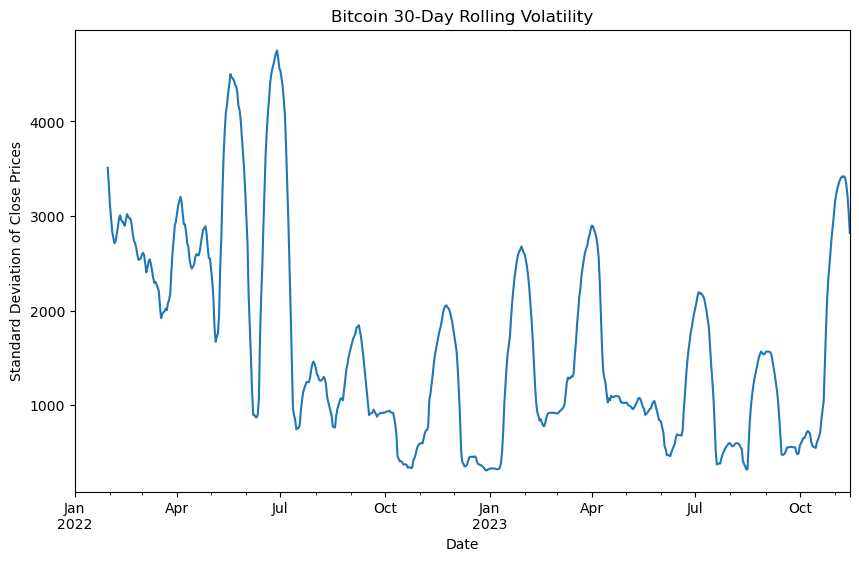

In [15]:
# EDA: Volatility Analysis
data['Close'].dropna().rolling(window=30).std().plot(figsize=(10, 6), title='Bitcoin 30-Day Rolling Volatility')  # Drop NaN values
plt.xlabel('Date')
plt.ylabel('Standard Deviation of Close Prices')
plt.show()

Median (50th percentile): 22722096615.0
First quartile (25th percentile): 15152659888.0
Third quartile (75th percentile): 30706097734.5
Interquartile Range (IQR): 15553437846.5
Lower Whisker: -8177496881.75
Upper Whisker: 54036254504.25
Outliers:
Date
2022-01-07    8.419661e+10
2022-05-09    6.335549e+10
2022-05-10    5.981104e+10
2022-05-11    7.038886e+10
2022-05-12    6.698917e+10
2022-06-13    6.820456e+10
2022-06-15    5.491201e+10
2022-09-27    5.857144e+10
2022-10-26    5.889595e+10
2022-11-02    5.555217e+10
2022-11-04    6.407273e+10
2022-11-08    1.189925e+11
2022-11-09    1.029052e+11
2022-11-10    8.320228e+10
2022-11-11    5.587162e+10
2023-03-14    5.462223e+10
Name: Volume, dtype: float64


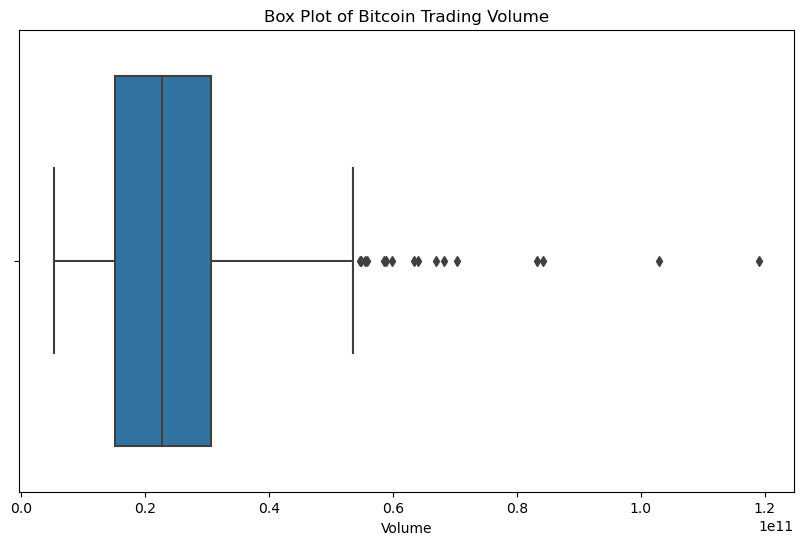

In [16]:
quartiles = data['Volume'].quantile([0.25, 0.5, 0.75])
iqr = quartiles[0.75] - quartiles[0.25]
lower_whisker = quartiles[0.25] - 1.5 * iqr
upper_whisker = quartiles[0.75] + 1.5 * iqr

print(f"Median (50th percentile): {quartiles[0.5]}")
print(f"First quartile (25th percentile): {quartiles[0.25]}")
print(f"Third quartile (75th percentile): {quartiles[0.75]}")
print(f"Interquartile Range (IQR): {iqr}")
print(f"Lower Whisker: {lower_whisker}")
print(f"Upper Whisker: {upper_whisker}")

# Detecting outliers
outliers = data['Volume'][(data['Volume'] < lower_whisker) | (data['Volume'] > upper_whisker)]
print(f"Outliers:\n{outliers}")

# Assuming data['Volume'] is already in a proper numeric format
plt.figure(figsize=(10, 6))
sns.boxplot(x=data['Volume'])
plt.title('Box Plot of Bitcoin Trading Volume')
plt.xlabel('Volume')
plt.show()

In [17]:
# # EDA: Time Series Decomposition Plots
# decomposition = seasonal_decompose(data['Close'].dropna(), model='additive', period=30)  # Drop NaN values
# fig = decomposition.plot()
# fig.set_size_inches(10, 8)
# fig.suptitle('Time Series Decomposition of Bitcoin Closing Price')
# plt.show()

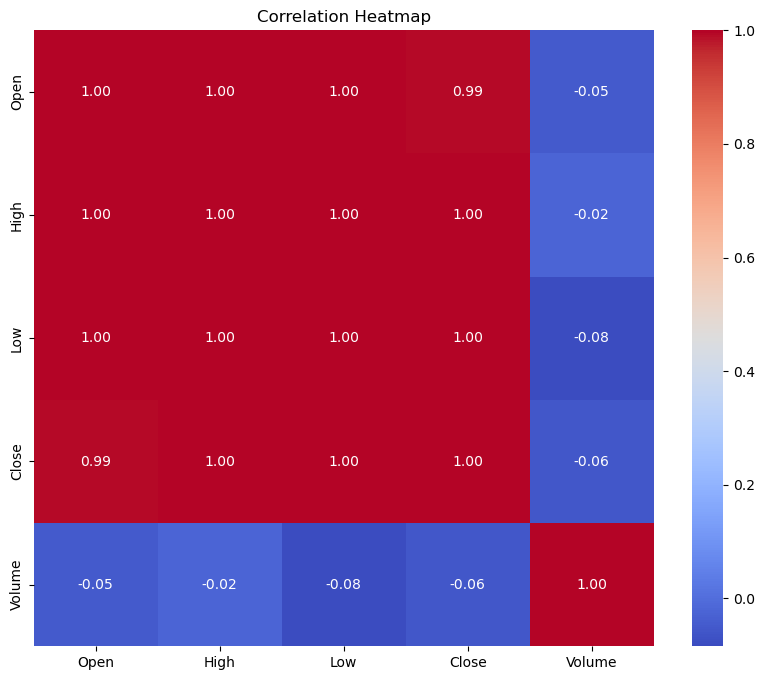

In [18]:
# EDA: Correlation Heatmaps
plt.figure(figsize=(10, 8))
sns.heatmap(data.dropna().corr(), annot=True, cmap='coolwarm', fmt=".2f")  # Drop NaN values
plt.title('Correlation Heatmap')
plt.show()


In [19]:
# Model Selection and Development
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [20]:
# Preparing data for additional models
X = scaled_data[:, :-1]  # All features except the target
y = scaled_data[:, 3]   # 'Close' price as the target

In [21]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [22]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)


In [23]:
# Random Forest
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)


In [24]:
# Neural Network
nn_model = MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=500)
nn_model.fit(X_train, y_train)
nn_predictions = nn_model.predict(X_test)

In [25]:
# Model Evaluation
print("Linear Regression MSE:", mean_squared_error(y_test, lr_predictions))
print("Random Forest MSE:", mean_squared_error(y_test, rf_predictions))
print("Neural Network MSE:", mean_squared_error(y_test, nn_predictions))

Linear Regression MSE: 1.5632365679989826e-32
Random Forest MSE: 4.3142181537693265e-05
Neural Network MSE: 6.322479456224125e-05


In [26]:
# Model Evaluation and Refinement: Cross-Validation, Hyperparameter Tuning (Example for Random Forest)
tscv = TimeSeriesSplit(n_splits=5)
param_grid = {'n_estimators': [100, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20]}
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=tscv, n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best Parameters for Random Forest:", grid_search.best_params_)

C:\Users\64724\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Best Parameters for Random Forest: {'max_depth': 10, 'max_features': 'auto', 'n_estimators': 100}


In [27]:
# Calculate the 10-day Simple Moving Average
data['SMA_10'] = data['Close'].rolling(window=10).mean()


In [28]:
# Define trading signals
data['strategy_signal'] = 0  # Default to no position
data['strategy_signal'][data['Close'] > data['SMA_10']] = 1  # Buy signal
data['strategy_signal'][data['Close'] < data['SMA_10']] = -1  # Sell signal


C:\Users\64724\AppData\Local\Temp\ipykernel_27560\2789256201.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['strategy_signal'][data['Close'] > data['SMA_10']] = 1  # Buy signal
C:\Users\64724\AppData\Local\Temp\ipykernel_27560\2789256201.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['strategy_signal'][data['Close'] < data['SMA_10']] = -1  # Sell signal


In [29]:
# Calculate daily returns
data['strategy_return'] = data['strategy_signal'].shift(1) * data['Close'].pct_change()

In [30]:
# Calculate cumulative returns
data['cumulative_strategy_return'] = (1 + data['strategy_return']).cumprod()
data['cumulative_market_return'] = (1 + data['Close'].pct_change()).cumprod()

In [31]:
# plt.figure(figsize=(12, 6))

# # Plotting the market and strategy cumulative returns
# plt.plot(data['cumulative_market_return'], label='Market Returns (Buy and Hold)')
# plt.plot(data['cumulative_strategy_return'], label='Strategy Returns')

# # Setting up a secondary y-axis for SMA
# ax2 = plt.gca().twinx()
# ax2.plot(data['Close'], color='lightgray', linestyle='--', label='Close Price')
# ax2.plot(data['SMA_10'], color='orange', linestyle='-', label='SMA 10')
# ax2.set_ylabel('Close Price and SMA 10')

# # Marking trade points
# # Buy signals: Close < SMA_10, Sell signals: Close > SMA_10
# buy_signals = data['Close'] > data['SMA_10']
# sell_signals = data['Close'] < data['SMA_10']

# ax2.plot(data[buy_signals].index, data['Close'][buy_signals], 'g^', label='Buy Signal', markersize=8)  # Green triangles for buy
# ax2.plot(data[sell_signals].index, data['Close'][sell_signals], 'rv', label='Sell Signal', markersize=8)  # Red triangles for sell

# # Adding legends
# lines, labels = plt.gca().get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# # Setting titles and labels
# plt.title('Backtesting Trading Strategy with SMA')
# plt.xlabel('Date')
# plt.ylabel('Cumulative Returns')

# plt.show()


In [32]:
# # Performance Metrics
# total_strategy_return = data['cumulative_strategy_return'].iloc[-1] - 1
# total_market_return = data['cumulative_market_return'].iloc[-1] - 1
# print(f"Total Strategy Return: {total_strategy_return:.2f}") 
# print(f"Total Market Return: {total_market_return:.2f}")
